In [1]:
from glob import glob
import torch
from typing import List
import torchvision
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from PIL import Image

In [2]:
filenames = glob("./dataset/json/*.tif")
len(filenames)

20

In [3]:
filenames.sort(key=lambda x: int(x.split(os.path.sep)[-1].split('.')[0]))
filenames

['./dataset/json\\201.tif',
 './dataset/json\\202.tif',
 './dataset/json\\203.tif',
 './dataset/json\\204.tif',
 './dataset/json\\205.tif',
 './dataset/json\\206.tif',
 './dataset/json\\207.tif',
 './dataset/json\\208.tif',
 './dataset/json\\209.tif',
 './dataset/json\\210.tif',
 './dataset/json\\211.tif',
 './dataset/json\\212.tif',
 './dataset/json\\213.tif',
 './dataset/json\\214.tif',
 './dataset/json\\215.tif',
 './dataset/json\\216.tif',
 './dataset/json\\217.tif',
 './dataset/json\\218.tif',
 './dataset/json\\219.tif',
 './dataset/json\\220.tif']

In [4]:
masks = [filename.replace('tif','json') for filename in filenames]
masks

['./dataset/json\\201.json',
 './dataset/json\\202.json',
 './dataset/json\\203.json',
 './dataset/json\\204.json',
 './dataset/json\\205.json',
 './dataset/json\\206.json',
 './dataset/json\\207.json',
 './dataset/json\\208.json',
 './dataset/json\\209.json',
 './dataset/json\\210.json',
 './dataset/json\\211.json',
 './dataset/json\\212.json',
 './dataset/json\\213.json',
 './dataset/json\\214.json',
 './dataset/json\\215.json',
 './dataset/json\\216.json',
 './dataset/json\\217.json',
 './dataset/json\\218.json',
 './dataset/json\\219.json',
 './dataset/json\\220.json']

In [5]:
def get_mask_by_json(filename:str):
    
    json_file = json.load(open(filename))
    img_height = json_file['imageHeight']
    img_width = json_file['imageWidth']
    mask = np.zeros((img_height,img_width),dtype='int8')
    for shape in json_file['shapes']:
        label = int(shape['label'])
        points = np.array(shape['points']).astype(np.int32)
        cv2.fillPoly(mask,[points],label)
    return mask

In [6]:
def pasteImages(images:List[np.ndarray]):
    """
    将两张图片粘贴在一起
    """
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]
    width = sum(widths)
    height = max(heights)
    paste_img = Image.new('RGB',(width,height))
    offset_x = 0
    for img in images:
        pil_img = Image.fromarray(img)
        paste_img.paste(pil_img,(offset_x, 0))
        offset_x += img.shape[1]
    return np.array(paste_img)

def give_colors_to_mask(image:np.ndarray, mask:np.ndarray,num_classes=6):
    image_tensor = torch.tensor(image).permute(2,0,1)
    masks = [mask == v for v in range(num_classes)]
    mask = np.stack(masks,axis=0).astype('bool')
    mask_tensor = torch.tensor(mask)
    colors = [
    "#ffffff",  # 白色    荒地
    "#a8d5ba",  # 浅绿    低覆盖度
    "#6cc551",  # 中浅绿   中低覆盖度
    "#4caf50",  # 中绿     中覆盖度
    "#388e3c",  # 中深绿    中高覆盖度
    "#1b5e20"   # 深绿     高覆盖度
    ]

    mask_colors = torchvision.utils.draw_segmentation_masks(image_tensor,mask_tensor,colors=colors,alpha=1.0).permute(1,2,0).numpy().astype(np.uint8)
    return mask_colors

In [7]:
all_images = None
for filename, mask_path in zip(filenames, masks):
    mask = get_mask_by_json(mask_path)
    image = np.array(Image.open(filename))
    mask_colors = give_colors_to_mask(image,mask)
    paste_img = pasteImages([image,mask_colors])

    paste_img = np.transpose(paste_img,(2,0,1))[np.newaxis]
    if all_images is None:
        all_images = paste_img
    else:
        all_images = np.concatenate((all_images, paste_img),axis=0)
all_images.shape

(20, 3, 256, 512)

In [8]:
all_images_tensor = torch.tensor(all_images)
all_images_tensor.shape

torch.Size([20, 3, 256, 512])

In [9]:
show_image = torchvision.utils.make_grid(all_images_tensor,nrow=5,padding=4)

In [10]:
show_image.shape

torch.Size([3, 1044, 2584])

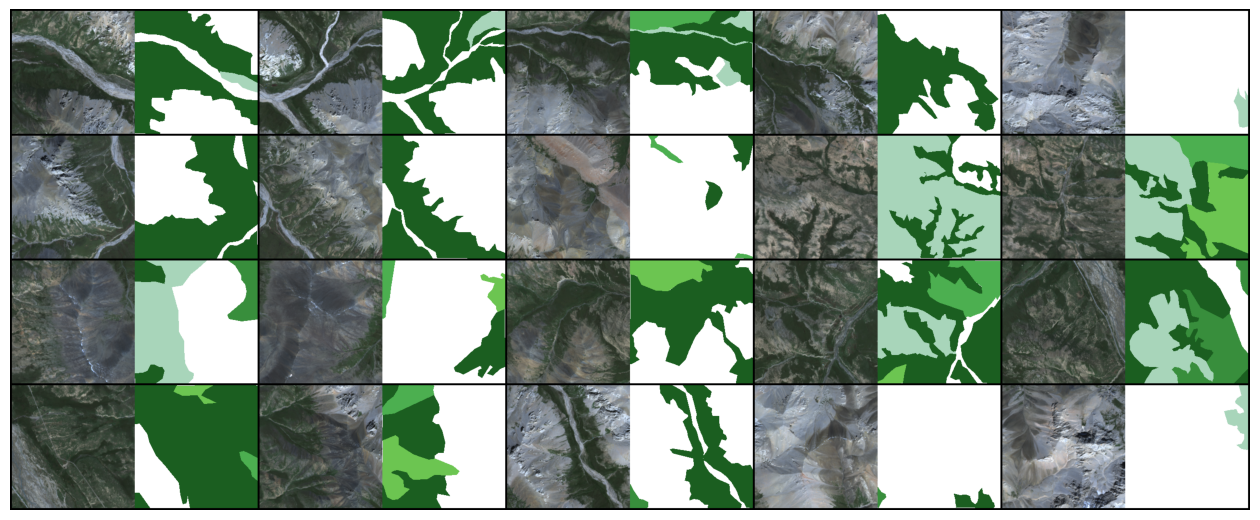

In [13]:
plt.figure(figsize=(16,12))
plt.axis("off")
plt.imshow(show_image.permute(1,2,0).numpy())
plt.show()